__Notebook Overview:__

This notebook is derived from an experimental analysis performed on visual stimulus experiments on zebrafish, carried out in the Draelos Lab at University of Michigan. More information on this experimental data, as well as links to the GitHub repo containing the analysis and the lab webiste are included in the README file in this repository (VisSimData).

The overall goal of this notebook is to perform a comprehensive analysis of simulated neural data. This notebook is designed to replicate a potential experimental workflow, informing us of how neural response patterns correspond to behavioral dynamics and motor movement in biological model organisms, for example. 

Characteristics of an experiment including the number of neurons, number of "stimuli" that occur, sampled characteristics of these stimuli, and more can be altered in the _Set Parameter for Simulated Data Generation_ section below.  

This data is generated from a Gaussian distribution and designed to provide a brief overview of how each analysis step is carried out and could apply to experimental data. For example, in an experimental design, we would want to carry out the steps outlined in this notebook to provide us with statistically significant insights into how specific visual stimulus parameters evoke neural responses of varying intensity.

The datasets used in this notebook (which are generated in the steps below if not already created) include 1) _stim_data.txt_: a text file with three columns; the first column representing the frame/time of stimulus occurrence, and the second and third columns representing theoretical characteristics of an imaginariy visual stimulus occurring (denoted by dimension 1 and dimension 2 respectively, and 2) _stim_response.txt_: a text file containing nxn arrays, where the each row is an individual neuron and each column represents a neuron's response at a given frame or point in time,

In [2]:
import math
import warnings
import numpy as np
from scipy.signal import savgol_filter
import matplotlib as cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap

__Set Parameters for Simulated Data Generation:__

The cell immediately below will set parameters to be used when generating the _stim_data.txt_ and _stim_responses.txt_ text files to be used for downstream analysis.

In [4]:
#set parameters for stim_data
stim_interval = 100 #interstimulus interval time
dim1_min = 1 #min x value
dim1_max = 10 #max x value
dim2_min = 1 #min y value
dim2_max = 10 #max y value

#set parameters for stim_responses
num_neurons = 10 #number of simulated neurons to generate
num_frames = 4000 #number of frames/response values per neuron
max_response = 20.0 #max response that a neuron's ap can reach (set for easier visualization)
no_response_prob = 0.3 #probability of stimulus not inducing any response

#set seed
seed = 42

__Simulated Data Generation:__

The functions in the following cells (_generate_stim_data_, _generate_ap_, and _generate_stim_responses_) will create the stim_data.txt and stim_responses.txt files that contain the simulated neural responses to stimulus occurrences. 

These two files will serve as the primary input for the rest of analysis performed in this notebook, and are saved to the directory containing this notebook.

_generate_stim_data_ will create the stim_data.txt file, containing three columns of values; the first representing the frame number where a theoretical visual stimulation would occur, inducing an action potential in the neuron(s) we are measuring. The second and third columns contain values that would represent specific characteristics of the visual stimulus being shown. For example, in an experimental context, this could represent a different stimulus shape, size, color, etc.

_generate_ap_ will produce a gaussian-like spike representing a simulated action potential after the visual stimulus is "shown", and _generate_stim_responses_ will append these respective spikes for each neuron and output the stim_responses.txt file containing these values.

In [6]:
def generate_stim_data():
    
    """
    Generates text file containing frame number and characteristics of visual stim occurrences

    Args:
        None

    Returns:
        num_stimuli (int): Number of stimuli occurrences in text file
    """
    
    np.random.seed(seed)
    #make values for stim onset
    col1 = np.arange(stim_interval, num_frames, stim_interval)

    num_stimuli = len(col1)

    #create random values for dim1 and dim2
    col2 = np.random.randint(dim1_min, dim1_max+1, size=num_stimuli)
    col3 = np.random.randint(dim2_min, dim2_max+1, size=num_stimuli)  
    
    #combine
    data = np.column_stack((col1, col2, col3))

    #save
    file_name = "stim_data.txt"
    np.savetxt(file_name, data, delimiter=' ', fmt='%d')
    num_stimuli = (num_frames // stim_interval)

    print(f"File {file_name} has been created with {num_stimuli-1} stimuli")
    
    return num_stimuli

num_stimuli = generate_stim_data()  

File stim_data.txt has been created with 39 stimuli


In [8]:
def generate_ap(width, amplitude):
    
    """
    Generates artifical action potential (ap) after stimulus occurrence

    Args:
        width (int): random integer between 5 and 50 representing width of ap
        amplitude (float): random float between 1 and max_response representing peak

    Returns:
        ap (float): value at given location along width of action potential for respective stim occurrence
    """
    
    ap = np.zeros(width)
    midpoint = width // 2
    
    #make Gaussian-like spike
    for i in range(width):
        ap[i] = amplitude * np.exp(-((i - midpoint) ** 2) / (2 * (width / 6) ** 2))
        
    return ap

def generate_stim_responses():
    
    """
    Generates each neuron's responses and outputs text file

    Args:
        None

    Returns:
        None, but generates stim_responses.txt file
    """
    
    np.random.seed(seed)
    #initialize matrix with zeros
    matrix = np.zeros((num_neurons, num_frames))

    #make aps and insert into matrix
    for i in range(1, num_stimuli):
        stimulus_start = i * stim_interval
        stimulus_end = stimulus_start + stim_interval

        for neuron in range(num_neurons):

            if np.random.rand() < no_response_prob:
                # No response for this stimulus
                continue

            #create random amplitude and width for each neuron
            amplitude = np.random.uniform(1, max_response) 
            width = np.random.randint(5, 50)
            ap = generate_ap(width, amplitude)

            #place ap into matrix
            ap_start = stimulus_start + np.random.randint(0, stim_interval - width)
            ap_end = ap_start + width
            matrix[neuron, ap_start:ap_end] += ap

    file_name = "stim_responses.txt"
    np.savetxt(file_name, matrix, fmt='%.2f')

    print(f"File {file_name} has been created for {num_neurons} neurons with {num_frames} responses")
    
generate_stim_responses()

File stim_responses.txt has been created for 10 neurons with 4000 responses


__Set File Locations of Simulated Data:__

After generating the simulated data above, we set the locations of the files to their respective response_data and stim_data variables to be reference throughout the rest of the analysis.

In [10]:
response_data = "./stim_responses.txt"
stim_data = "./stim_data.txt"

__Retrieve Neural Responses:__

The function below creates a dictionary (_neurons_responses_dict_) where each key is a different neuron and the values for each neuron represent the strength of response at each frame.

If this was experimental data, these values would represent the respective neuron's response over time while it is being recorded after multiple stimulus appearances. Based on the imaging/recording method, it is likely that artifacts or very low-quality neurons would be recorded during the experiment as well. This would require an additional filtering or QC step to ensure that only high-quality neurons are being taken into analysis.

Since the goal of this project is to attempt to perform an analysis that closely mimics the steps required of experimental data, we also correct for "background noise", or in the simulated case, randomness. We apply a Savitzky-Golay filter to our population average to create a smoothed, fitted line to our data that represents a "baseline". This baseline is used to normalize each individual neuron's signal to help reduce simulated background noise and bring out real peaks. 

In [12]:
def get_responses():
    
    """
    Retrieves responses at each frame for each neuron, calculates averages, and corrects 'background noise'
    
    Args:
        None

    Returns:
        neuron_responses_corrected (dict): dict of all neurons and their corrected responses
        avg_responses_dict (dict): dict of the avg response of each frame across all neurons
        savgol_avg (array): Fitted smoothed line using Savitzky-Golay filter representing average to correct for noise
    """
    
    with open(response_data, 'r') as file:
        neurons_responses = file.readlines()
        
    neurons_responses_dict = {key:[] for key in range(1, (len(neurons_responses)+1))}

    #append response at each frame for each neuron
    for neuron in range(len(neurons_responses)):
        neurons_responses_dict[neuron+1] = neurons_responses[neuron].strip("\n").split(" ")
        
    for neuron, responses in neurons_responses_dict.items():
        neurons_responses_dict[neuron] = [float(response) for response in responses if response != 'nan']
    
    responses_list = list(iter(neurons_responses_dict.values()))
    
    avg_responses_dict={'N_avg':[] for value in range(num_frames)}

    #get frame averages column-wise
    for response in range(len(responses_list[0])):
        frame_list = [frame[response] for frame in responses_list] 
        avg_responses_dict['N_avg'].append(sum(frame_list)/len(frame_list)) 
        
    #apply savitzky-golay smoothed filter to avg responses  
    avg_responses_list = list(iter(avg_responses_dict.values()))
    avg_responses_array = np.array(avg_responses_list)
    savgol_avg = savgol_filter(avg_responses_array, 300, 3) 

    neurons_responses_corrected = {}

    #correct each neuron by dividing response at each frame by savgol-fitted avg response at each frame
    for neuron, responses in neurons_responses_dict.items():
        corrected_responses = []
        for frame, response in enumerate(responses):
            corrected_responses.append(response / savgol_avg[0][frame])

        neurons_responses_corrected[neuron] = corrected_responses
    
    return neurons_responses_corrected, avg_responses_dict, savgol_avg, 
        
neurons_responses_corrected, avg_responses_dict, savgol_avg = get_responses()

__Plot Neural Traces:__

We can visualize the traces of each neuron below, where the blue line indcates the neuron's response over the course of the "experiment". Additionally, stimuli appearances are indicated by either orange or green vertical bars in the background, depending on whether dim1 or dim2 is chosen to be displayed. 

Different neurons within the dataset can also be displayed by changing the _neuron_ argument to any number between 1 and _num_neurons_ defined in the parameter sections at the beginning of the notebook.

In [14]:
def neural_traces(parameter, neuron, plot_filter):
    
    """
    Plots specified neuron's response after stimulus occurrences over time

    Args:
        parameter (str): parameter to be used as index for vertical lines indicating stimulus occurrence ('dim1' or 'dim2')
        neuron (int/str): neuron to be plotted (int between 1:num_neurons), or average of all neurons ('all')
        plot_filter (bool): trace representing SG filter fitted response average used to correct background noise

    Returns:
        None, but plots neural trace for indicated neuron(s)
    """
    
    with open(stim_data) as file:
        stimuli = file.readlines()

    stimuli_list = []
    frames_list = []

    #append list of frames where stimulus occurrence appears
    for i in zip(stimuli):
        stimuli_list.append(i[0].split(" ", 1)[0])
        frames_list.append(i[0].strip("\n").split(" "))

    stimuli_list = [eval(y) for y in stimuli_list] #convert scientific notation to decimals
    stimuli_list.sort()

    param_list = []

    #append values of parameter corresponding to stimulus shown at respective frame
    for i in frames_list:
        if parameter == 'dim1':
            param_list.append(float(i[2]))
        elif parameter == 'dim2':
            param_list.append(float(i[1]))

    if parameter == 'dim1':
        original_cmap = cm.colormaps["Oranges"]
        dim_min = dim1_min
        dim_max = dim2_max
    elif parameter == 'dim2':
        original_cmap = cm.colormaps["Greens"]
        dim_min = dim2_min
        dim_max = dim2_max

    #truncate colorbar
    new_colors = original_cmap(np.linspace(0.2, 1))
    truncated_cmap = LinearSegmentedColormap.from_list('truncated_cmap', new_colors)

    param_list = np.array(param_list) 
    norm = Normalize(dim_min, vmax=dim_max) 

    fig, ax = plt.subplots(figsize=(12, 6))
    
    if neuron == 'all':
        ax.plot(range(num_frames), avg_responses_dict.get("N_avg"), label = "Avg Neural Response")
        plt.title(f"Avg Neural Response")
    else:
        if neuron in neurons_responses_corrected.keys():
            ax.plot(range(num_frames), neurons_responses_corrected.get(neuron))
            plt.title(f"Neuron {neuron} Neural Response")
        else:
            print("Neuron not in dictionary. Please choose different neuron")

    for stimulus, param_val in zip(stimuli_list, param_list):
        ax.axvline(x=stimulus, color = truncated_cmap(norm(param_val)), linewidth = "0.5")
        
    if plot_filter == True:
        ax.plot(range(num_frames), savgol_avg[0], color = 'g', linewidth = '0.5')

    sm = plt.cm.ScalarMappable(cmap=truncated_cmap, norm=norm)
    sm.set_array(param_list)
    cbar = plt.colorbar(sm, ax=ax, label = f'{parameter}')
    plt.xlim(0, num_frames)
    plt.ylim(0, max_response)
    plt.xlabel("Frames")
    plt.ylabel("Response Strength")
    plt.tight_layout()
    
    plt.show()

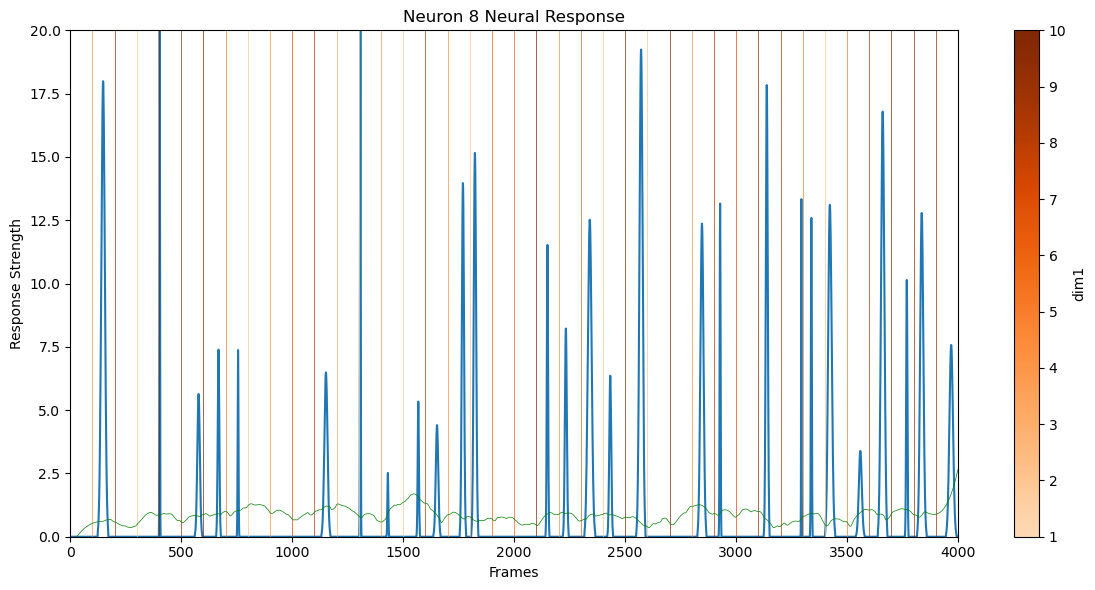

In [16]:
neural_traces("dim1", 8, True)

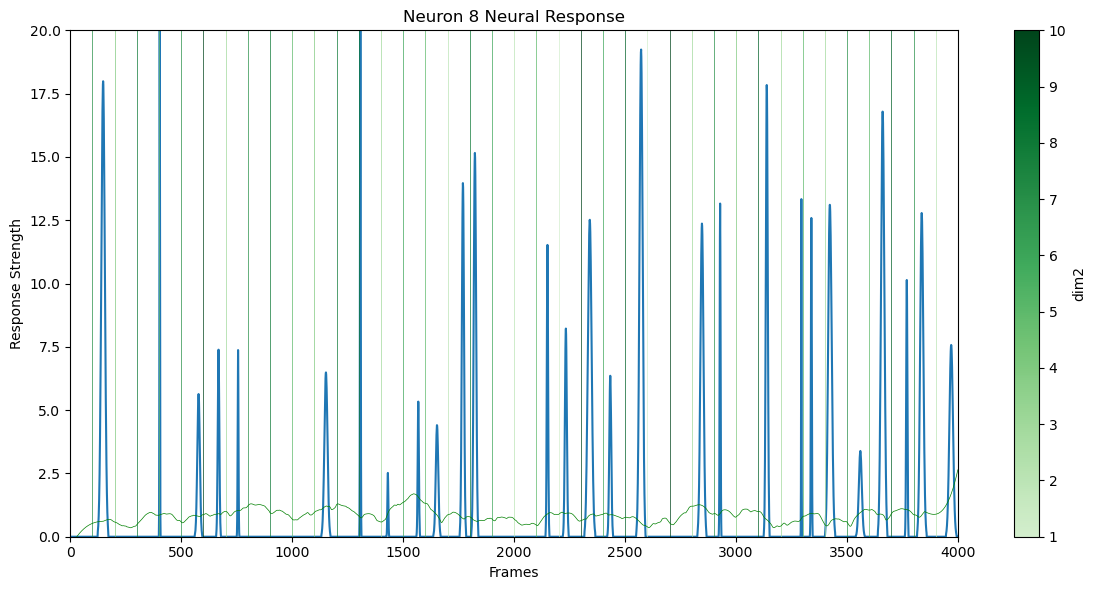

In [18]:
neural_traces("dim2", 8, True)

Neuron 8's response over time is shown above, and defined by distinct blue peaks representing neural responses. Orange or green vertical bars in the background represent the onset of stimuli, shaded by their value for dimension1 or dimension2. A fitted green line is also plotted along with the neural trace to display the Savitzky-Golay fitted filter line used to correct for background noise.

In an experimental context, we could plot the neural responses at each frame for all neurons in our dataset to visualize patterns or distributions in our neural population. These patterns could inform us of specific combinations of parameters, such as values of dim1 and dim2 which represent different characteristics of a visual stimuli, that are responsible for eliciting the greatest neural responses within a subpopulation.

However, since this is randomly generated data based off of a normal distribution, the average neural response below is significantly less informative. Additionally, the simulated data generated above does not have any real noise associated with it, which is obviously unlike experimental neural signals. Regardless, we can interpet randomness from our small sample size as variance in signal caused by our stimulus occurrences, even though this is clearly not the case.

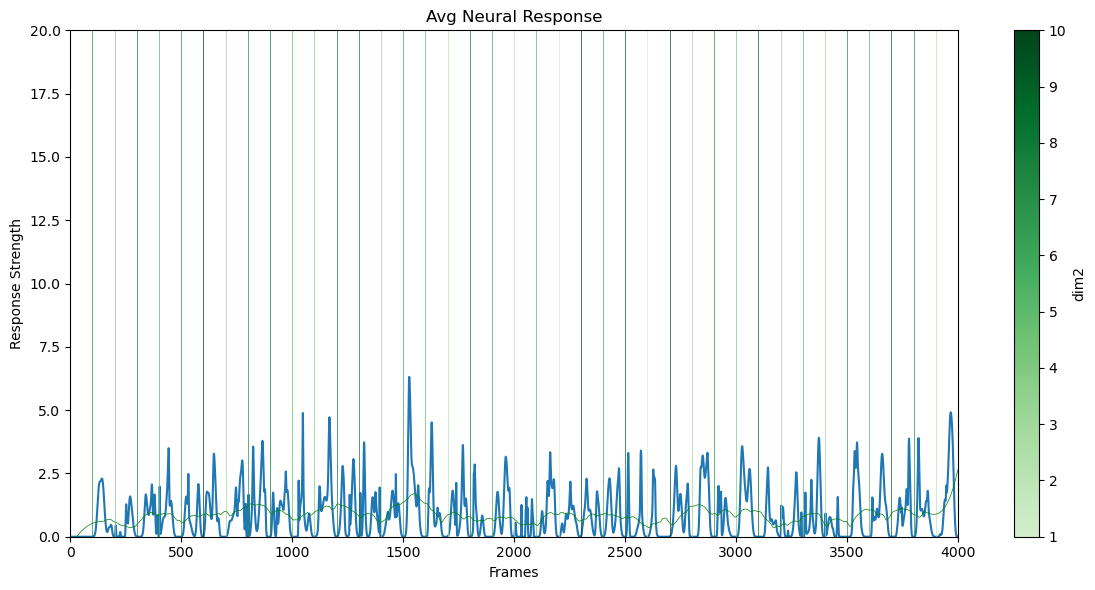

In [20]:
neural_traces("dim2", 'all', True)

__Parameter-Specific Peak Structure:__

Building upon our findings from the neural traces above, the section below aims to extract information regarding how specific values of dim1 and dim2 (our theoretical visual stimulus) elicits changes in neural response shape and distribution during stimulus onset across the population of cells.

Subplots that are left blank are a result of a lack of sampling during the simulated data generation.

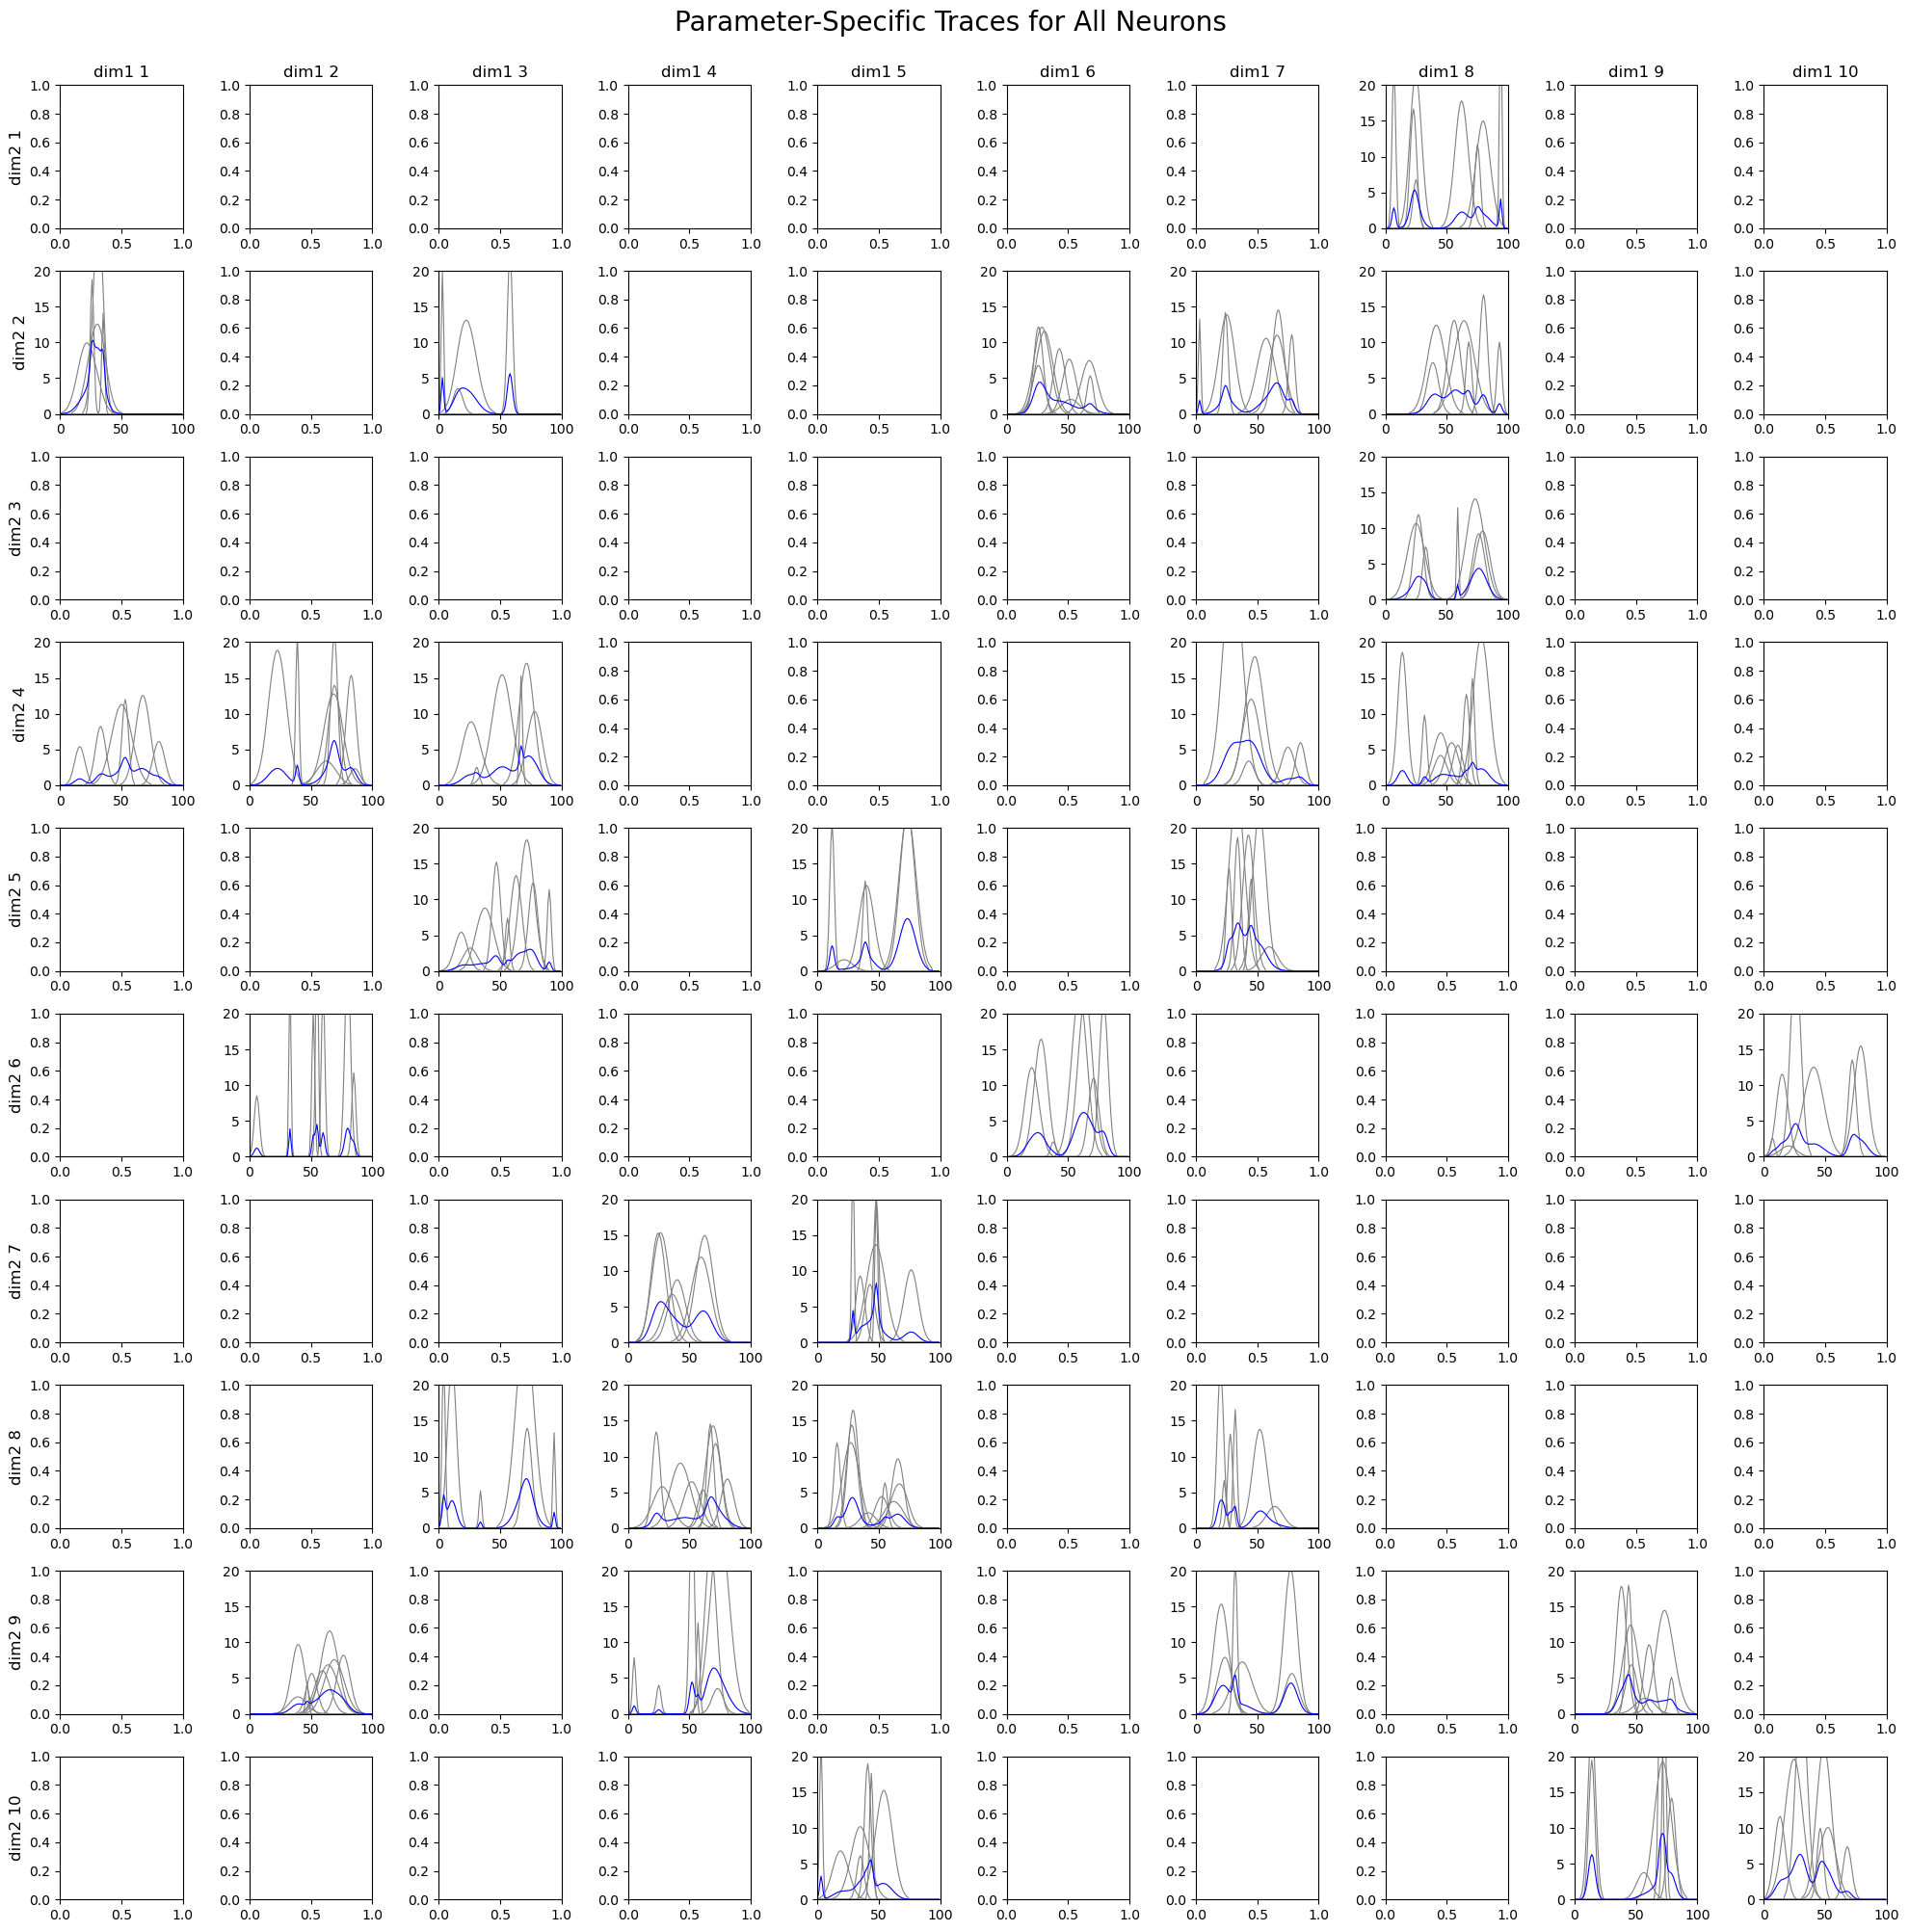

In [24]:
def stim_combo_analysis():
    
    """
    Retrieves stimulus info from sim_data.txt file

    Args:
        None

    Returns:
        all_stim_info (list): list containing characteristics for each stimulus occurrence 
    """
    
    with open(stim_data) as file:
        stimuli = file.readlines()
        
    all_stim_info = []
    for i in zip(stimuli):
        all_stim_info.append(i[0].strip("\n").split(" "))
    
    #convert stim to floats and append to list
    for idx, stim in enumerate(all_stim_info):
        stim = [eval(param) for param in stim]
        all_stim_info[idx] = stim
    
    return all_stim_info

def stim_combo_plot_indiv(ax, all_stim_info, neuron, val1, val2):
    
    """
    Plots each individual neuron's stimulus-specific traces

    Args:
        ax (array): array of subplots for individual traces to be plotted
        all_stim_info (list): list containing characteristics for each stimulus occurrence 
        neuron (int/str): neuron to be plotted (int between 1:num_neurons), or average of all neurons ('all')
        val1 (int): value associated with dimension 1 for corresponding sitmulus
        val2 (int): value associated with dimension 2 for corresponding stimulus

    Returns:
        traces_avg (dict): dict containing stim occurrence frames with subsequent values at following frames
    """
    
    stim_combo_start = []
    
    #find frame where param combo occurs
    for stim in all_stim_info:
        if val1 == stim[1] and val2 == stim[2]:
            stim_combo_start.append(int(stim[0]))

    if len(stim_combo_start) > 0:
        
        #find window length corresponding to stimulus onset
        traces_avg = {}
        for stim in stim_combo_start:
            traces_avg[stim] = [[] for i in range(stim_interval)]

            #iterate through each neuron and append response at respective frame to corresponding position in dictionary
            if neuron == 'all':
                for neuron in neurons_responses_corrected:
                    if sum(neurons_responses_corrected[neuron][stim:stim+stim_interval]) >= 10: 
                        ax.plot(range(0, stim_interval), neurons_responses_corrected[neuron][stim:stim+stim_interval], color = "grey", lw = '0.8')

                        for val_idx, val in enumerate(neurons_responses_corrected[neuron][stim:stim+stim_interval]):
                            traces_avg[stim][val_idx].append(val)
                      
            else:
                if sum(neurons_responses_corrected[neuron][stim:stim+stim_interval]) >= 10: 
                    ax.plot(range(0, stim_interval), neurons_responses_corrected[neuron][stim:stim+stim_interval], color = "grey", lw = '0.8')

                    for val_idx, val in enumerate(neurons_responses_corrected[neuron][stim:stim+stim_interval]):
                        traces_avg[stim][val_idx].append(val)
                else:
                    traces_avg.pop(stim)
                        
        if len(traces_avg) == 0:
            traces_avg = None
                                  
    else:
        traces_avg = None
     
    plt.ylim(0,max_response)
    
    return traces_avg
                                                        
def stim_combo_plot_avg(ax, traces_avg):
    
    """
    Computes average response for each stim onset window and plots trace

    Args:
        ax (array): array of subplots for individual traces to be plotted
        traces_avg (dict): dict containing stim occurrence frames with subsequent values at following frames

    Returns:
        None, but plots average trace for each dimension combo
    """
    
    #truncate or extend dict to be same length (max_window)
    for frame, response in traces_avg.items():
        if len(response) > stim_interval:
            traces_avg[frame] = traces_avg[frame][:stim_interval]
        elif len(response) < stim_interval:
            traces_avg[frame].append([0] * (stim_interval - len(response)))
                       
    values = [[] for i in range(stim_interval)]
    for i in range(stim_interval):
        for key, responses in traces_avg.items():
            for response in responses[i]:
                if response != None:
                    values[i].append(response)

    #calculate average at each frame for all responses in stim window
    avg_list = []
    for i in values:
        if len(i) > 0:
            average = sum(i)/len(i)
            avg_list.append(average)
            
    if len(avg_list) > 0:
        ax.plot(range(0,len(avg_list)), avg_list, color = "blue", lw = "0.8")
        ax.set(xlim=(0,len(avg_list)), ylim = (0,max_response))
        
    plt.ylim(0,max_response)
    
def stim_combo_show(neuron):
    
    """
    Iterates through each neuron in dataset and displays subplot of traces

    Args:
        neuron (int/str): neuron to be plotted (int between 1:num_neurons), or average of all neurons ('all')

    Returns:
        None, but displays subplot for each trace associated with parameter-specific combination
    """

    all_stim_info = stim_combo_analysis()

    param1 = list(range(dim1_min, dim1_max+1))
    param2 = list(range(dim2_min, dim2_max+1))

    rows = ['dim1 {}'.format(row) for row in param1]
    cols = ['dim2 {}'.format(col) for col in param2]

    fig, axs = plt.subplots(len(param1), len(param2), figsize = (20,20))
    if neuron == 'all':
        fig.suptitle('Parameter-Specific Traces for All Neurons', fontsize = 20, x=0.5, y=1)
    else:
        fig.suptitle(f'Parameter-Specific Traces for Neuron {neuron}', fontsize = 20, x=0.5, y=1)
    for ax, row in zip(axs[0], rows):
        ax.set_title(row)

    for ax, col in zip(axs[:,0], cols):
        ax.set_ylabel(col, rotation=90, size='large')
    axs = axs.flatten()

    param_idx = 0

    #iterate through each combo of size-speed and analyze corresponding stimON window
    for val2 in param2:
        for val1 in param1:
            traces_avg = stim_combo_plot_indiv(axs[param_idx], all_stim_info, neuron, val1, val2)
            if traces_avg != None:
                stim_combo_plot_avg(axs[param_idx], traces_avg)
            param_idx += 1

    plt.tight_layout()
    plt.show()
        
stim_combo_show('all')

__Non-interpolated Tuning Curves:__

Having identified potential patterns in neural response structure and location during the stimulus onset window, our next step is to identify which parameter combinations most consistently induce the greatest neural responses. 

This can be accomplished by plotting non-interpolated neural tuning curves, which highlight the amplitude of response across all neurons in our population and map them to their specific stimulus that induced the response.

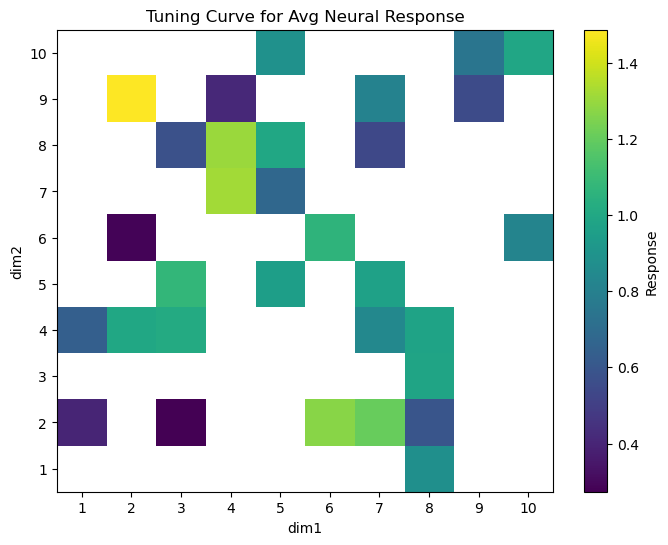

In [38]:
def tuning_curves_analysis(neuron):
    
    """
    Calculates average response for specified neuron(s) and maps response to stimulus characteristics

    Args:
        neuron (int/str): neuron to be plotted (int between 1:num_neurons), or average of all neurons ('all')

    Returns:
        all_combos (array): array of every unique combo between possibly tested parameters
        responses_map (dict): average of responses associated with a combo of possibly tested parameters
        avg_map (dict): average of responses associated with a combo of tested parameters
        stim_responses (dict): contains stim onset frame and the subsequent responses at the following frames
        param1 (list): list of possible sampled values for dimension1
        param1_frames (dict): contains tested values of dim1 as keys and frames of matching stim onset responses as values
        param2 (list): list of possible sampled values for dimension2
        param2_frames (dict): contains tested values of dim2 as keys and frames of matching stim onset responses as values
    """
    
    all_stim_info = stim_combo_analysis()
    
    param1 = list(range(dim1_min, dim1_max+1))
    param2 = list(range(dim2_min, dim2_max+1))
    all_combos = np.array([(x, y) for x in param1 for y in param2])
    
    param1_frames = {key:[] for key in param1}
    param2_frames = {key:[] for key in param2}
        
    #appending frame of matching unqiue param tested as value
    for stim in all_stim_info:
        stim_param1 = stim[1]
        stim_param2 = stim[2]
        
        for param in param1:
            if param == stim_param1:
                param1_frames[param].append(stim[0])
                
        for param in param2:
            if param == stim_param2:
                param2_frames[param].append(stim[0])
               
    #dict that will contain stimulus onset frame and the neural responses within the stimulus window
    stim_responses = {}

    #assign the values (stimulus onset frames) from parameter_uniqvals_frames_dict their own dict as a key
    for param, frames in param1_frames.items():
        for frame in frames:
            stim_responses[frame] = []
            
    for frame, response in stim_responses.items():
        frame_idx = 0
        for stim in all_stim_info:
            frame_idx += 1

            #finding range/window of frames that correspond to stimulus onset
            if frame == stim[0] and frame_idx < len(all_stim_info):
                frame_start = int(frame)
                frame_end = int(all_stim_info[frame_idx][0])

                #adding neural response frames that correspond to selected stimulus window
                if neuron == 'all':
                    for avg_frame in avg_responses_dict['N_avg'][frame_start:frame_end]:
                        stim_responses[frame].append(avg_frame)
                        
                else:
                    for neuron_frame in neurons_responses_corrected[neuron][frame_start:frame_end]:
                        stim_responses[frame].append(neuron_frame)

            #identifying frame window when analyzing last stimulus onset
            elif frame == stim[0] and frame_idx == len(all_stim_info):
                frame_start = int(frame)
                frame_end = int(len(avg_responses_dict['N_avg']))

                #adding neural response frames that correspond to selected stimulus window
                if neuron == 'all':
                    for avg_frame in avg_responses_dict['N_avg'][frame_start:frame_end]:
                        stim_responses[frame].append(avg_frame)
                        
                else:
                    for neuron_frame in neurons_responses_corrected[neuron][frame_start:frame_end]:
                        stim_responses[frame].append(neuron_frame)
    
    #calculating average of all responses within selected window for each different stimulus onset
    for stim, responses in stim_responses.items():
        if len(responses) == 0:
            stim_responses[stim] = np.nan
        else:
            stim_responses[stim] = (sum(responses)/len(responses))
                
    stim_responses = sorted(stim_responses.items())
            
    for idx, i in enumerate(stim_responses):
        all_stim_info[idx].append(i[1])
        
    responses_map = {}
    avg_map = {}
    for row in all_combos:
        responses_map[tuple(row)] = []
        avg_map[tuple(row)] = []
    
    #appending average values associated with unique combo of parameters
    for combo in avg_map:
        for stim in all_stim_info:
            if combo[0] == stim[1] and combo[1] == stim[2]:
                responses_map[combo].append(stim[3])
                avg_map[combo].append(stim[3])
    
    #calculating average and replacing non-sampled spaces with nan
    for combo, response in avg_map.items():
        if len(response) > 0:
            avg_map[combo] = sum(response)/len(response)
            if avg_map[combo] == 0:
                avg_map[combo] = np.nan
        else:
            avg_map[combo] = np.nan
                        
    return all_combos, responses_map, avg_map, stim_responses, param1, param1_frames, param2, param2_frames

def tuning_curves_plot(neuron):
    
    """
    plots non-interpolated tuning curves for specified neuron(s)

    Args:
        neuron (int/str): neuron to be plotted (int between 1:num_neurons), or average of all neurons ('all')

    Returns:
        None, but plots non-interpolated tuning curve for specified neuron(s)
    """
    
    all_combos, responses_map, avg_map, stim_responses, param1, param1_frames, param2, param2_frames = tuning_curves_analysis(neuron)
    
    fig, ax = plt.subplots(figsize=(8, 6))

    known_values = np.array([response for response in avg_map.values() if response])
    
    interped_data = known_values.reshape(len(param1), len(param2))
    
    plt.imshow(interped_data.T, origin = 'lower', aspect = 'auto')
    plt.colorbar(label='Response')
    plt.xlabel('dim1')
    plt.ylabel('dim2')
    plt.xticks(np.arange(len(param2)), param2)
    plt.yticks(np.arange(len(param1)), param1)
    if neuron == 'all':
        plt.title('Tuning Curve for Avg Neural Response')
    else:
        plt.title(f'Neuron {neuron} Tuning Curve')
     
    plt.show()
    
tuning_curves_plot('all')

From the above tuning curve we can identify a peak at dim1 = 2 and dim2 = 9, indicating a neural preference for a theoretical visual stimulus that contains these characteristics. 

Continuing the analysis, we can further extract information regarding the neural population's preferences. More specifically, whether this peak we have identified is statistically significant, and if it is more likely to be a result of the change in value of dimension1 or dimension2.

First, however, it is beneficial to produce subplots of tuning curves for each of the neurons in our simulated dataset. This way, we can identify whether this peak identified above is a result of a single, outlying response or a uniform response across many neurons.

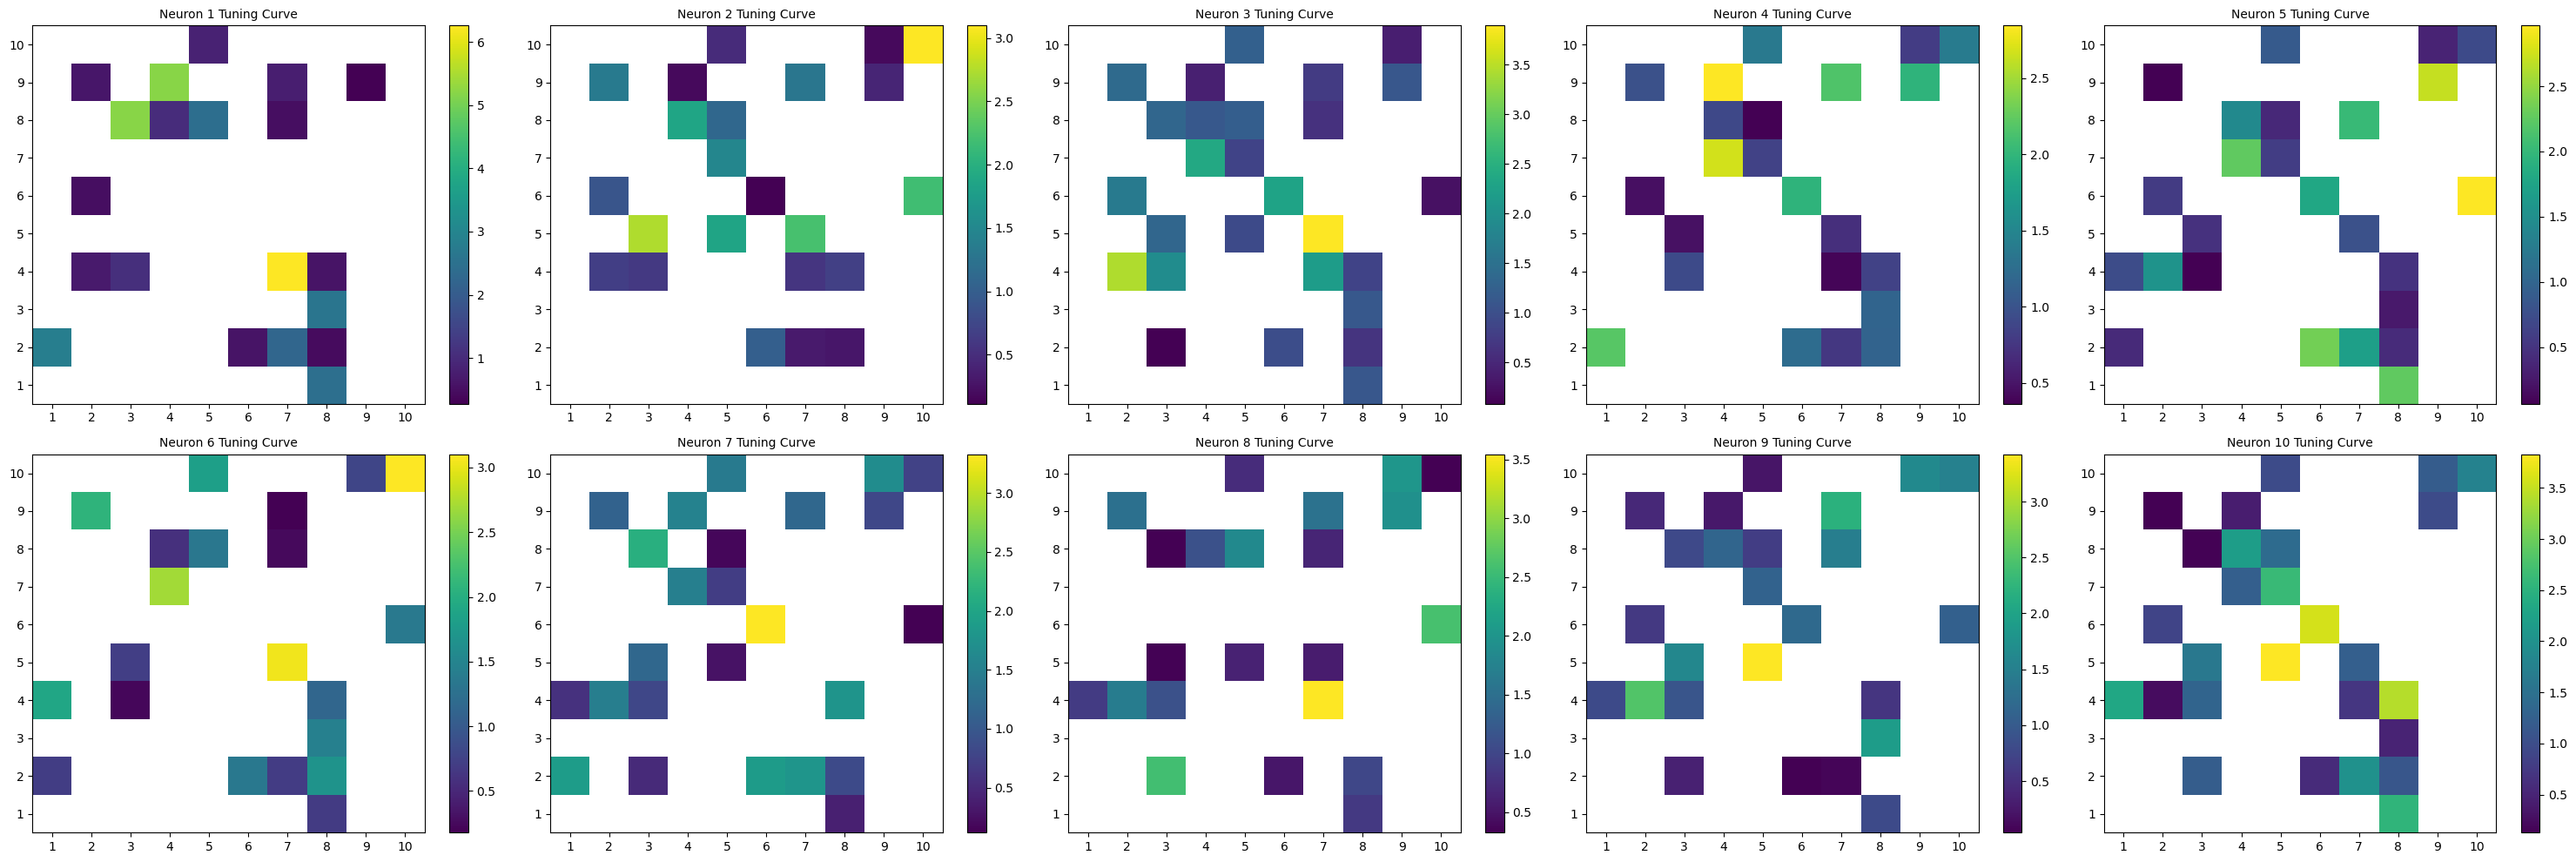

In [30]:
def tuning_curve_subplots_analysis(neuron):
    
    """
    Obtains average response for each dimension combo and reshapes array

    Args:
        neuron (int/str): neuron to be plotted (int between 1:num_neurons), or average of all neurons ('all')

    Returns:
        interped_data (array): array reshaped to length of tested dimensions with average response values
        param1 (list): list of possible sampled values for dimension1
        param2 (list): list of possible sampled values for dimension2
    """
    
    all_combos, responses_map, avg_map, stim_responses, param1, param1_frames, param2, param2_frames = tuning_curves_analysis(neuron)
    
    known_values = np.array([response for response in avg_map.values() if response])
    
    interped_data = known_values.reshape(len(param1), len(param2))
    
    return interped_data, param1, param2

def tuning_curves_subplots_plot(interped_data, param1, param2, neuron, ax, fig):
    
    """
    Creates non-interpolated tuning curve for each neuron

    Args:
        interped_data (array): array reshaped to length of tested dimensions with average response values
        param1 (list): list of possible sampled values for dimension1
        param2 (list): list of possible sampled values for dimension2
        neuron (int/str): neuron to be plotted (int between 1:num_neurons), or average of all neurons ('all')
        ax (array): array of subplots for individual tuning curves to be plotted
        fig (figure): plot to be edited for specific neuron
        
    Returns:
        None, but creates subplots for non-interpolated tuning curves of every neuron
    """
    
    #plot data
    cax = ax.imshow(interped_data.T, origin = 'lower', aspect = 'auto')
    ax.set_title(f'Neuron {neuron} Tuning Curve', fontsize = 10)
    param1_label = [str(val) for val in param1]
    param2_label = [str(val) for val in param2]
    ax.set(xticks=range(0, len(param2), 1), xticklabels=param2_label, yticks=range(0, len(param1), 1), yticklabels=param1_label)
    fig.colorbar(cax, ax=ax)
    
def tuning_curves_subplots_show():
    
    """
    Displays each neuron's non-interpolated tuning curve

    Args:
        None
        
    Returns:
        None, but displays subplots for non-interpolated tuning curves of every neuron in dataset
    """

    #define subplots
    fig, axs = plt.subplots(math.ceil(len(neurons_responses_corrected.keys())/5), 5, figsize = (30,10))
    axs = axs.flatten()

    #obtain data
    neuron_idx = 0
    for neuron in neurons_responses_corrected:
        interped_data, param1, param2 = tuning_curve_subplots_analysis(neuron)
        tuning_curves_subplots_plot(interped_data, param1, param2, neuron, axs[neuron_idx], fig)
        neuron_idx += 1

    plt.tight_layout()
    plt.show()

tuning_curves_subplots_show()

Displaying individual neurons above highlights underlying patterns within our population. The previously identified peak across all neurons at dimension1 = 2 and dimension2 = 9 appears to be a local peak for 2/10 neurons and highly responsive for a separate 4/10 neurons, supporting the likelihood that this is a true peak rather than an outlier.

These results hold more power in an experimental context. If we were equipped with the information above, and each dimension represented a specific characteristic of a visual stimuli (say dimension1 = speed and dimension2 = size), we could state that our model organism has a higher preference and reaction to visual stimuli that move slowly and are also large in size. Depending on the motor movement or behavior being studied, this would also provide some insight on which visual stimuli characteristics are most likely to be connected to dynamic motor movements.

__Parameter-Specific Responses:__

While we can visually identify patterns using the tuning curves and other plots above, we need to identify whether these peaks are statistically significant. Furthermore, due to the nature of how the data was generated using random sampling, it is also important to take into consideration response intensity variation, which is purely a result of sampling differences or changes in the _no_response_prob_ variable. The plots below aim to address these aspects and inform us of potentially significant findings.

In [41]:
def parameter_responses_analysis(parameter, neuron):
    
    """
    Calculates average and stdev of responses corresponding to each value of sampled dimensions

    Args:
        parameter (str): parameter for averages to be calculated
        neuron (int/str): neuron to be plotted (int), or average of all neurons ('all')
        
    Returns:
        param_mean (dict): contains sampled values of parameter as keys and the average neural response after stim occurrence with that sampled value
        param_stdev (dict): contains sampled value of parameter as keys and the stdev across averages of different stim occurrence as values
    """
    
    all_combos, responses_map, avg_map, stim_responses, param1, param1_frames, param2, param2_frames = tuning_curves_analysis(neuron)
    all_stim_info = stim_combo_analysis()
    
    if parameter == "dim1":
        param = param1
        param_frames = param1_frames
    elif parameter == 'dim2':
        param = param2
        param_frames = param2_frames

    param_mean = {param:[] for param in param}
    param_stdev = {param:[] for param in param}
    
    for frameON, val in stim_responses:
        for stim in all_stim_info:
            if frameON == stim[0]:
                if parameter == 'dim1':
                    param_mean[stim[1]].append(val)
                elif parameter == 'dim2':
                    param_mean[stim[2]].append(val)
                    
    warnings.filterwarnings("ignore", category=RuntimeWarning)
            
    for param, vals in param_mean.items():
        stdev = np.array([vals])
        mean = np.array([vals])
        param_mean[param] = np.nanmean(mean[0], axis = 0, )
        param_stdev[param] = np.nanstd(stdev[0], axis = 0)
        
    return param_mean, param_stdev
        
def parameter_responses_plot(parameter, neuron):
    
    """
    Plot average and stdev of responses corresponding to each value of sampled dimensions

    Args:
        parameter (str): parameter for averages to be calculated
        neuron (int/str): neuron to be plotted (int), or average of all neurons ('all')
        
    Returns:
        None, but plots averages with error bars for sampled values of the indicated parameter
    """
    
    param_mean, param_stdev = parameter_responses_analysis(parameter, neuron)
        
    x = []
    y = []
    yerr = []

    #add frame of stimulus onset to x-axis and average response to stimulus as y-axis
    for param, mean in param_mean.items():
        x.append(param)
        y.append(mean)

    #add std dev as error bars
    for param, stdev in param_stdev.items():
        yerr.append(stdev)

    fig, ax = plt.subplots()
    ax.errorbar(x, y, yerr, fmt='o', linewidth=2, capsize=6)

    if parameter == "dim1":
        ax.set_ylim(bottom=0)
        ax.set_xlim(0,dim1_max+1)
    if parameter == "dim2":
        ax.set_ylim(bottom=0)
        ax.set_xlim(0,dim2_max+1)

    if neuron == "all":
        plt.title(f'Avg Neural Response Given {parameter}')
    else:
        plt.title(f'Neuron {neuron} Avg Response Given {parameter}')

    plt.xlabel(f'{parameter}')
    plt.ylabel("Avg Response")

    plt.show()

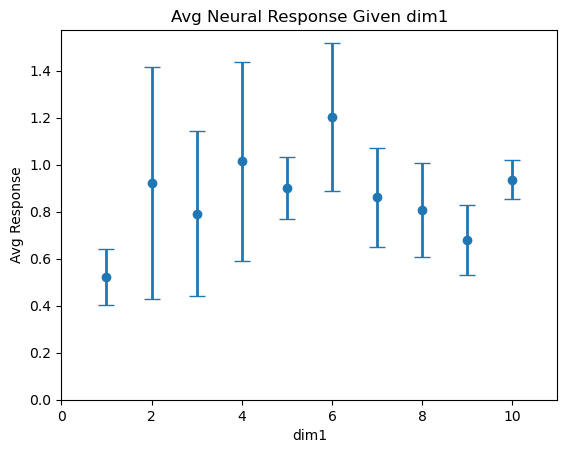

In [43]:
parameter_responses_plot('dim1', 'all')

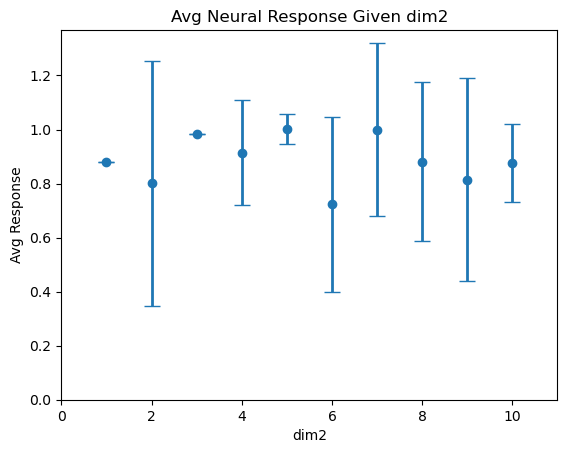

In [45]:
parameter_responses_plot('dim2', 'all')

Disparities in sampling across both dimensions is evident due to the lower variance described by small error bars in the plots above.

We can conclude that neither a value of 2 for dimension1 or a value of 9 for dimension2 are statistically significant. This provides us wth an important undertanding of how sampling and response strength may be directly tied to the frequency of sampling. 

With an increased sample size in both neurons and sampling size, we expect these results to further become less significant (and eventually insignificant) due to the normal distribution the data generation is based off. Keeping the sample size low in this case, however, aims to replicate skewed or significant findings that are more likely to occur in an experimental context.

__Sampling Space Heatmap:__

Another potential factor that can be impacting the average response of our neural population is the rate of sampling specific parameter combinations. Although dimension1 at value 2 and dimension2 at value 9 induce the greatest response, this may simply be due to this combination of parameters being sampled more than others. 

We can plot heatmaps of the rate that each parameter combo was sampled below providing us with information regarding neural response given sampling variance.

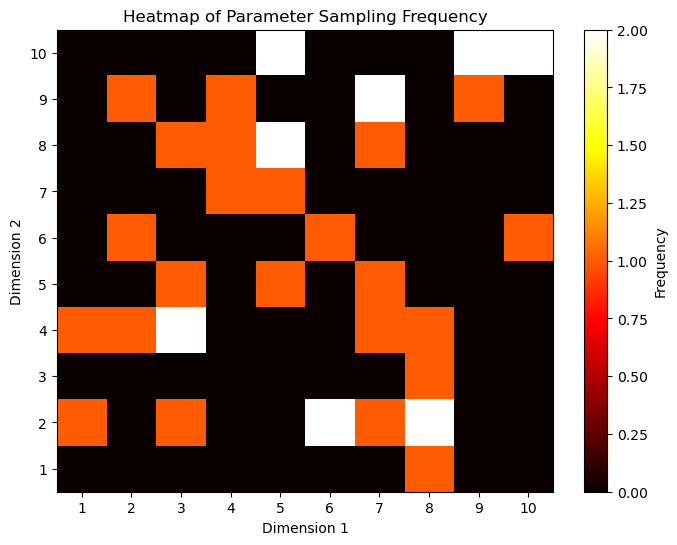

In [47]:
def sampling_heatmap():
    
    """
    interprets and plots heatmap of sampling frequencies for unique combos of sampled dimensions

    Args:
        None
        
    Returns:
        None, but plots sampling frequency heatmap
    """
    
    neuron = next(iter(neurons_responses_corrected.keys()))
    all_combos, responses_map, avg_map, stim_responses, param1, param1_frames, param2, param2_frames = tuning_curves_analysis(neuron)
    all_stim_info = stim_combo_analysis()
    
    sampled_combos = list((combo[1:3]) for combo in all_stim_info)
    
    freq_map = {}
    for combo in all_combos:
        combo = tuple(combo)
        freq_map[combo] = 0
        
    #identify how often each sampling combo appears during experiment
    for combo in sampled_combos:
        combo = tuple(combo)
        if combo in all_combos:
            freq_map[combo] += 1
              
    #create array by retrieving key tuple corresponding to appearance frequency
    heatmap = np.zeros((len(param1), len(param2)))
    for dim1_idx, dim1 in enumerate(param1):
        for dim2_idx, dim2 in enumerate(param2):
            heatmap[dim1_idx, dim2_idx] = freq_map.get((dim1, dim2), 0)
            
    fig, ax = plt.subplots(figsize=(8, 6))
    
    plt.imshow(heatmap.T, cmap = 'hot', origin = 'lower', aspect = 'auto')
    plt.colorbar(label='Frequency')
    plt.title(f'Heatmap of Parameter Sampling Frequency')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.xticks(np.arange(len(param2)), param2)
    plt.yticks(np.arange(len(param1)), param1)
    
    plt.show()
    
sampling_heatmap()

The heatmap above illustrates sampling disparities across our sampling space. By comparing the heatmap above to the neural tuning curves from earlier, we can visually identify a lack of correlation between sampling frequency and response strength. This result makes sense considering this simulated data is generated from a Gaussian distribution, where random variance will have a less significant effect on response intensity, which is exacerbated by our smaller neuron sample size.

However, if we were to interpret the heatmap above in an experimental context, this plot would help us be able to distinguish whether our large peak at dimension1 = 2 and dimension2 = 9 is real signal, and not a result of over sampling. 

__Response Frequency Heatmap:__

Below we display the frequency in which an individual (or population of neurons) respond to a given theoretical visual stimuli with a specific parameter combination for dimensions 1 and 2. This enables us to quantitatively identify the magnitude of responses to specific parameters, and can be used in conjunction with the tuning curves and sampling heatmap above to describe both neural response strength and frequency.

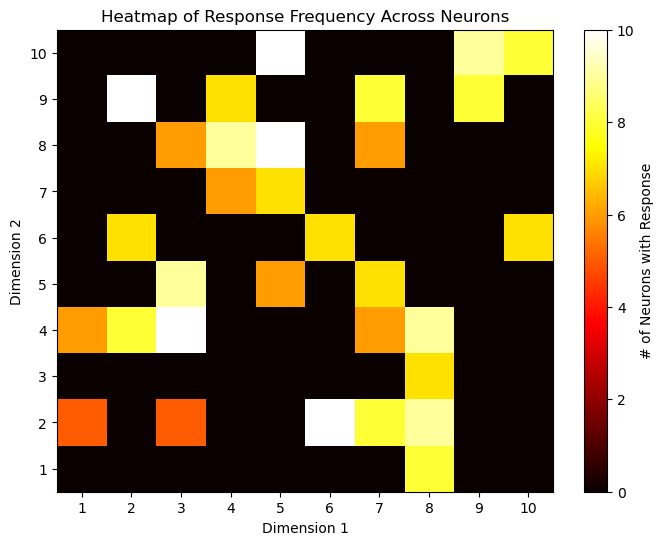

In [49]:
def response_heatmap_analysis(neuron):
    
    """
    Identifies and collects stimulus windows that elicit positive neural responses for each neuron 
    
    Args:
        neuron (int/str): neuron to be plotted (int), or average of all neurons ('all')
        
    Returns:
        response_master_map (dict): contains the number of neurons that have a positive response to the associated dimension combo
        param1 (list): list of possible sampled values for dimension1
        param2 (list): list of possible sampled values for dimension2
    """
    
    param1 = list(range(dim1_min, dim1_max+1))
    param2 = list(range(dim2_min, dim2_max+1))
    all_combos = np.array([(x, y) for x in param1 for y in param2])
    
    response_master_map = {}
    for row in all_combos:
        response_master_map[tuple(row)] = 0

    if neuron == 'all':
        for neuron in neurons_responses_corrected.keys():
            all_combos, responses_map, avg_map, stim_responses, param1, param1_frames, param2, param2_frames = tuning_curves_analysis(neuron)
    
            #append response if greater than minimum response threshold (arbitrary value)
            for combo, responses in responses_map.items():
                for response in responses:
                    if response >= 0.05:
                        response_master_map[combo] += 1
                        break
                        
    else:
        all_combos, responses_map, avg_map, stim_responses, param1, param1_frames, param2, param2_frames = tuning_curves_analysis(neuron)
    
        #append response if greater than minimum response threshold (arbitrary value)
        for combo, responses in responses_map.items():
            for response in responses:
                if response >= 0.05:
                    response_master_map[combo] += 1
                        
    return response_master_map, param1, param2
                        
def response_heatmap_plot(neuron):
    
    """
    plots heatmap of neurons that had a positive response to a specific combo of sampled parameters 
    
    Args:
        neuron (int/str): neuron to be plotted (int), or average of all neurons ('all')
        
    Returns:
        None, but plots neural response heatmap
    """
                          
    response_master_map, param1, param2 = response_heatmap_analysis(neuron)

    fig, ax = plt.subplots(figsize=(8, 6))

    #create array by retrieving key tuple corresponding to appearance frequency
    heatmap = np.zeros((len(param1), len(param2)))
    for dim1_idx, dim1 in enumerate(param1):
        for dim2_idx, dim2 in enumerate(param2):
            heatmap[dim1_idx, dim2_idx] = response_master_map.get((dim1, dim2), 0)

    plt.imshow(heatmap.T, cmap = 'hot', origin = 'lower', aspect = 'auto')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.xticks(np.arange(len(param2)), param2)
    plt.yticks(np.arange(len(param1)), param1)

    if neuron == 'all':
        plt.colorbar(label='# of Neurons with Response')
        plt.title(f'Heatmap of Response Frequency Across Neurons')
    else:
        plt.colorbar(label='# of Responses')
        plt.title(f'Neuron {neuron} Heatmap of Response Frequency')

    plt.show()
    
response_heatmap_plot('all')

The heatmap above demonstrates which dimension combinations elicit a positive response across our entire population of neurons, regardless of the amplitude of signal. Here, we are analyzing frequency of signal rather than magnitude. We can observe our peak of interest at dimension1 = 2 and dimension2 = 9 has a positive response from every neuron in our analyzed dataset.

For simulated data, the differences in parameter respone frequency is directly tied to the _no_response_prob_ variable, which is set to 0.3 by default. In an experimental context, this heatmap would be much more informative and could be used in combination with the following heatmap below in order to identify the location of each neuron's strongest response.

__Peak Response Heatmap:__

Having already identified the frequency of peak distributions across all neurons, we can dive into finding the location of each neuron's peak response. This will provide us with further confidence that a specific combination of dimension parameters is inducing the greatest response, and can be double checked with the tuning curves created earlier in this analysis.

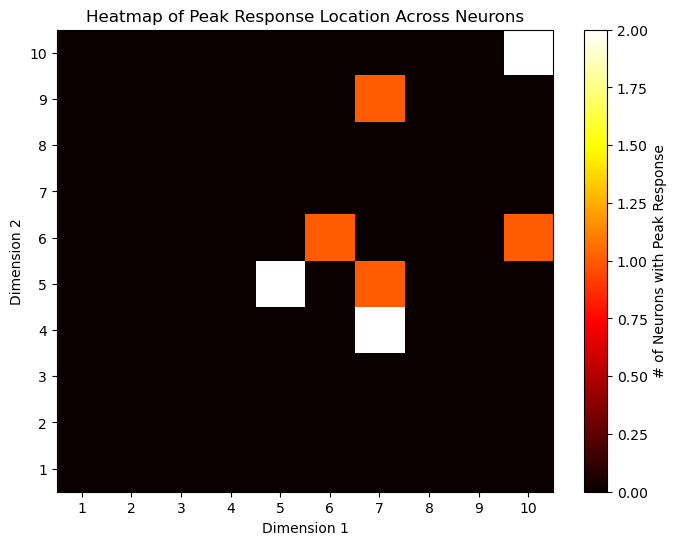

In [51]:
def peak_heatmap_analysis(neuron):
    
    """
    Identifies and collects stimulus windows that evoked the greatest positive neural response for each neuron 
    
    Args:
        neuron (int/str): neuron to be plotted (int), or average of all neurons ('all')
        
    Returns:
        peak_map (dict): contains the number of neurons that have their largest peak associated with a respective parameter combo
        param1 (list): list of possible sampled values for dimension1
        param2 (list): list of possible sampled values for dimension2
    """
    
    param1 = list(range(dim1_min, dim1_max+1))
    param2 = list(range(dim2_min, dim2_max+1))
    all_combos = np.array([(x, y) for x in param1 for y in param2])
    
    peak_map = {}
    for row in all_combos:
        peak_map[tuple(row)] = 0
        
    if neuron == 'all':
        for neuron in neurons_responses_corrected.keys():
            all_combos, responses_map, avg_map, stim_responses, param1, param1_frames, param2, param2_frames = tuning_curves_analysis(neuron)

            #identifies peak response across neuron's neural trace
            peak = 0.05
            for combo, responses in responses_map.items():
                for response in responses:
                    if response >= peak:
                        peak = response

            #appends +1 for parameter combo associated with stim inducing peak
            for combo, vals in responses_map.items():
                for val in vals:
                    if val == peak:
                        peak_map[combo] += 1
                        
    else:
        all_combos, responses_map, avg_map, stim_responses, param1, param1_frames, param2, param2_frames = tuning_curves_analysis(neuron)

        #identifies peak response across neuron's neural trace
        peak = 0.05
        for combo, responses in responses_map.items():
            for response in responses:
                if response >= peak:
                    peak = response
                    
        #appends +1 for parameter combo associated with stim inducing peak
        for combo, vals in responses_map.items():
            for val in vals:
                if val == peak:
                    peak_map[combo] += 1
                
    return peak_map, param1, param2

def peak_heatmap_plot(neuron):
    
    """
    plots heatmap of location of peak response across all neurons 
    
    Args:
        neuron (int/str): neuron to be plotted (int), or average of all neurons ('all')
        
    Returns:
        None, but plots peak neural response heatmap
    """
                                                
    peak_map, param1, param2 = peak_heatmap_analysis(neuron)

    fig, ax = plt.subplots(figsize=(8, 6))

    #create array by retrieving key tuple corresponding to appearance frequency
    heatmap = np.zeros((len(param1), len(param2)))
    for dim1_idx, dim1 in enumerate(param1):
        for dim2_idx, dim2 in enumerate(param2):
            heatmap[dim1_idx, dim2_idx] = peak_map.get((dim1, dim2), 0)

    plt.imshow(heatmap.T, cmap = 'hot', origin = 'lower', aspect = 'auto')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.xticks(np.arange(len(param2)), param2)
    plt.yticks(np.arange(len(param1)), param1)

    if neuron == 'all':
        plt.colorbar(label='# of Neurons with Peak Response')
        plt.title(f'Heatmap of Peak Response Location Across Neurons')
    else:
        plt.colorbar(label='Peak Location')
        plt.title(f'Neuron {neuron} Peak Response Location')

    plt.show()
    
peak_heatmap_plot('all')

Due to the data being generated from a Gaussian distribution, the peak heatmap above is not entirely informative - we can see that peak response for our neurons in this dataset is relatively disperse, but favors higher values for dimensions1 and dimensions2.

Again, in an experimental context, we could cross-validate our results from the peak response heatmap with the tuning curves and other heatmaps above to ensure that the combination of parameters identified that induce the greatest neural response are truly an average, and not a result of a single outlier response or artifact. In the heatmap above, we would be speciifcally intrigued of the combinations with higher peak responses, due to their higher prevalency.

All of the plots and analysis performed above aim to elucidate the relationship between dimensions 1 and 2 and neural response strength, while controlling/accounting for changing variables such as sampling frequency, sample size, response variance, and response probability. In an applicable lab context, this analysis could be utilized to inform future experiments on specific parameters/dimensions of interest that may be linked to hidden dynamics that require complex neural activity and responses, such as motor movement or behavior. 